## importar librerias

In [34]:
import cv2
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

## ir al directorio de las fotos y tomas los nombres de las carpetas

In [38]:
local_path = os.getcwd()
fotos_path = os.path.join(local_path, 'fotos-training')
fotos_path = os.path.join(fotos_path, 'training')
fotos_path = os.path.join(fotos_path, 'derecha')
labels = os.listdir(fotos_path)
labels_path = []
for l in labels:
    labels_path.append(os.path.join(fotos_path,l))

## Aca renombre todas las imagenes de cada carpeta porque eran una caos

In [39]:
os.listdir(labels_path[0])
nombre_fotos = []
for l in labels_path:
    fotos = os.listdir(l)
    i = 1
    for f in fotos:
        os.rename(os.path.join(l,f), os.path.join(l,f'{i}.jpg'))
        i +=1

## Cargo las imagenes, calculo los momentos y armo un dataframe con estos

In [40]:
Hu_moments = []
for l in labels_path:
    for f in os.listdir(l):
        img = cv2.imread(os.path.join(l,f))
        im = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        _,im = cv2.threshold(im, 128, 255, cv2.THRESH_BINARY)
        HU = cv2.HuMoments(cv2.moments(im)).ravel().tolist()
        HU.append(os.path.basename(os.path.normpath(l)))
        Hu_moments.append(HU)

In [41]:
columns = ['m1','m2','m3','m4','m5','m6','m7','p-p-t']
df = pd.DataFrame(Hu_moments,columns=columns)
df.to_csv('huMoments.csv')

In [42]:
df.describe()

,m1,m2,m3,m4,m5,m6,m7
count,264.000000,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02
mean,0.001362,5.190053e-07,1.557781e-09,1.510024e-10,-1.619089e-20,-7.129765e-14,-4.669455e-20
std,0.000199,1.712878e-07,7.964366e-10,1.024437e-10,7.369296e-20,5.772165e-14,1.529798e-19
min,0.001072,2.894203e-07,5.743846e-10,4.658343e-11,-1.825158e-19,-3.152397e-13,-7.324870e-19
25%,0.001208,3.936534e-07,1.007799e-09,8.840630e-11,-4.185328e-20,-8.511130e-14,-3.889406e-20
50%,0.001299,4.762236e-07,1.303075e-09,1.137806e-10,-2.336378e-20,-5.852766e-14,-6.020733e-21
75%,0.001491,5.977027e-07,1.851189e-09,1.781267e-10,-9.646193e-21,-3.905367e-14,6.161528e-21
max,0.001918,1.105253e-06,4.632665e-09,5.021318e-10,4.633260e-19,9.536280e-14,2.303653e-19


In [43]:
grupos = df.groupby('p-p-t')
grupos.mean()

,m1,m2,m3,m4,m5,m6,m7
p-p-t,,,,,,,
papel,0.001548,6.554904e-07,2.265345e-09,2.278990e-10,-2.155114e-20,-1.144294e-13,-9.992894e-20
piedra,0.001236,4.180938e-07,1.011198e-09,8.912060e-11,-1.016092e-20,-3.723523e-14,-4.046405e-21
tijeras,0.001266,4.605043e-07,1.283325e-09,1.242251e-10,-1.643497e-20,-5.548193e-14,-2.792125e-20


## separo los datos segun sean los de entrada o salida

In [44]:
x_columns = [x for x in columns if x != 'p-p-t']
x = df[x_columns]
y = df['p-p-t']

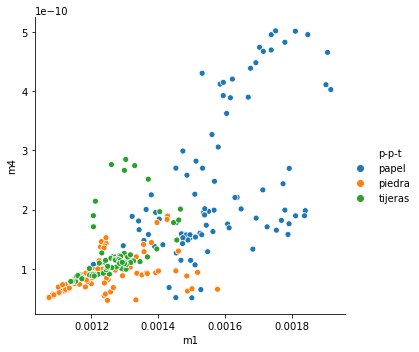

In [46]:
sns.relplot(data=df,x='m1',y='m4', hue='p-p-t')

## Escalar los datos: al haber tanta diferencia entro los distintos parametros los escalamos todos asi ninguno tiene mas peso que el otro

In [47]:
standar = StandardScaler()
scaler = standar.fit(df[x_columns])
x_new = pd.DataFrame(scaler.transform(x[x.columns]),columns=x_columns)

In [48]:
pd.concat([x_new,y],axis=1)

,m1,m2,m3,m4,m5,m6,m7,p-p-t
0,0.857026,0.436831,0.964603,2.733472,4.604552,1.141250,-1.563460,papel
1,1.226879,1.201072,1.716186,2.069078,-0.245987,-2.005711,-2.127900,papel
2,1.175104,1.027911,1.466120,2.364050,1.305331,-1.527946,-2.302216,papel
3,1.129616,0.931952,1.325873,2.554043,2.402123,-1.049871,-2.289994,papel
4,1.176651,1.000746,1.474835,2.582765,2.308280,-1.084378,-2.407729,papel
...,...,...,...,...,...,...,...,...
259,-0.349087,-0.254187,-0.310240,-0.393147,-0.113752,0.264645,0.080784,tijeras
260,-0.267713,-0.169443,-0.236623,-0.303726,-0.062373,0.297239,0.017952,tijeras
261,-0.225801,-0.135854,-0.206698,-0.268648,-0.031146,0.318394,-0.007276,tijeras
262,-0.805506,-0.686464,-0.588912,-0.616935,-0.149702,0.276246,0.300662,tijeras


## Primer modelo estimativo, modelo usado SVM

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y,random_state=31)
C = 10
gamma = 0.2
modelo = svm.SVC(C=C, kernel='rbf').fit(x_train,y_train)
#modelo = svm.SVC(C=C, kernel='rbf')
#score = cross_val_score(modelo, x_new, y, scoring="accuracy", cv=10, n_jobs=1)
y_pred = modelo.predict(x_test)

## Cuando vi que el modelo podia funcionar arme la grid para probar distintos parametros

In [50]:
params_grid =[
    {
        'kernel':['rbf'],
        'gamma':[1e-4,1e-3,1e-2, 0.1, 0.2, 0.5],
        'C':[1,10,100,1000]
    },
    {
        'kernel':['linear'],
        'C':[1,10,100,1000]
    }
]
gscv = GridSearchCV(svm.SVC(),param_grid=params_grid, cv=5)

In [57]:
model = gscv.fit(x_train,y_train)
clasifier = model.best_estimator_

## Analizo los resultados de la grid Search

In [52]:
print(model.best_params_)
print(model.best_score_)
#print(model.cv_results_)

{'C': 1000, 'gamma': 0.2, 'kernel': 'rbf'}
0.9392307692307693


In [31]:
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for m, s, p in zip(means, stds, params):
    print(f"{m} (+/-{2*s}) para {p}")

0.35215946843853824 (+/-0.008137839677020524) para {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.6055370985603544 (+/-0.048411343848732684) para {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.7746400885935769 (+/-0.07555816841780748) para {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.9339977851605757 (+/-0.05607700496683606) para {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.934108527131783 (+/-0.03642047360548301) para {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.967109634551495 (+/-0.04848222284904899) para {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.6055370985603544 (+/-0.048411343848732684) para {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.7746400885935769 (+/-0.047409981710210124) para {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.9152823920265781 (+/-0.04932681606050964) para {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.953266888150609 (+/-0.06578334092535948) para {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.9719822812846068 (+/-0.03474969418818192) para {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.

## Hago las predicciones usando el mejor estimador y analizo los resultados

In [53]:
y_pred = clasifier.predict(x_test)

In [54]:
print(classification_report(y_test, y_pred,labels=labels))

              precision    recall  f1-score   support

       papel       0.97      1.00      0.98        29
      piedra       0.76      0.94      0.84        17
     tijeras       1.00      0.75      0.86        20

    accuracy                           0.91        66
   macro avg       0.91      0.90      0.89        66
weighted avg       0.92      0.91      0.91        66



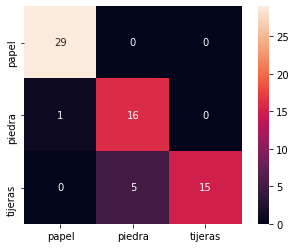

In [55]:
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, xticklabels=labels, yticklabels=labels)

In [56]:
print(accuracy_score(y_pred,y_test))

0.9090909090909091


## Guardamos el modelo asi no hay que seguir entrenandolo cada vez

In [98]:
with open('modelHU-SVM.pickle', 'wb') as f:
    pickle.dump(clasifier,f)

In [66]:
with open('estandarizador-HU.pickle', 'wb') as f:
    pickle.dump(scaler, f)

#### en caso que lo queramos importar de nuevo

In [2]:
with open('modelHU-SVM.pickle', 'rb') as f:
    clasifier = pickle.load(f)

In [3]:
with open('estandarizador-HU.pickle', 'rb') as f:
    scaler = pickle.load(f)